In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import random

In [ ]:
def display_image(img,label):
  plt.imshow(img.squeeze(0),cmap = "gray")
  plt.title(f"Label:{label}")
  plt.axis("off")
  plt.show()



# Dataset Stuff


In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
print(data.shape)
# First item in each row is the label and the rest of it (784) belongs to the image
ds = data[:5000:,1:]
labels = data[:5000,0]

dsNorm = ds/np.max(ds)

dsNorm = dsNorm.reshape(dsNorm.shape[0],1,28,28) #We need to reshape the image to convert it into an image

print(f"Data Set shape {dsNorm.shape}")
print(f"Labels shape {labels.shape}")




(20000, 785)
Data Set shape (5000, 1, 28, 28)
Labels shape (5000,)


In [ ]:
print("Data set type:", type(dsNorm))
print("Labels type:",type(labels))


dataTensor = torch.tensor(dsNorm,dtype=torch.float32)
labelsTensor = torch.tensor(labels,dtype=torch.float32)

print("Data set type:", type(dataTensor))
print("Labels type:",type(labelsTensor))

Data set type: <class 'numpy.ndarray'>
Labels type: <class 'numpy.ndarray'>
Data set type: <class 'torch.Tensor'>
Labels type: <class 'torch.Tensor'>


In [ ]:
# We will split the dataset of 5000 images into a trainset and testset
# Train set will roughly be 80% of the entire ds and the rest will be used for testing

train_data,test_data,train_labels,test_labels = train_test_split(dataTensor,labelsTensor,train_size=.8)
test_data,val_data,test_labels,val_labels = train_test_split(test_data,test_labels,train_size=.5)

print(f"Train data shape: {train_data.shape}, Type: {train_data.dtype}")
print(f"Train label shape: {train_labels.shape}, Type: {train_labels.dtype}\n")
print(f"Test data shape: {test_data.shape}, Type: {test_data.dtype}")
print(f"Test data shape: {test_labels.shape}, Type: {test_labels.dtype}\n")
print(f"Val data shape: {val_data.shape}, Type: {val_data.dtype}")
print(f"Val data shape: {val_labels.shape}, Type: {val_labels.dtype}\n")


#Converting to a TensorDataset Object -> basically making it an iterator to make life easy
trainDS = TensorDataset(train_data,train_labels)
testDS = TensorDataset(test_data,test_labels)
valDS = TensorDataset(val_data,val_labels)
#Creating a DataLoader for batch Training

trainLoader = DataLoader(trainDS,batch_size=64,shuffle=True,drop_last=True)
testLoader = DataLoader(testDS,batch_size=testDS.tensors[0].shape[0],shuffle=True,drop_last=True)
valLoader = DataLoader(valDS,batch_size=valDS.tensors[0].shape[0],shuffle=True,drop_last=True)




Train data shape: torch.Size([4000, 1, 28, 28]), Type: torch.float32
Train label shape: torch.Size([4000]), Type: torch.float32

Test data shape: torch.Size([500, 1, 28, 28]), Type: torch.float32
Test data shape: torch.Size([500]), Type: torch.float32

Val data shape: torch.Size([500, 1, 28, 28]), Type: torch.float32
Val data shape: torch.Size([500]), Type: torch.float32



# What we've done so far
 1. Imported data from colab into a numpy array
 2. Split the data into the dataset itself and corresponding labels
 3. Normalized the data so the max  = 1 and min = 0

 4. Reshaped the numpy array to convert the 1 d array into a 2d array for tensors
  5. Converted the numpy array to tensor
  
  6. Did a train-test-split
  7. Created a TensorData set object
  8. Created data loaders for batch training

# CNN

There a couple of important concepts in CNN

1. Convolution
2. Pooling
3. Stride
4. Padding


output after conv = [(input-kernel + 2 * padding)/Stride] + 1

output after pooling = [(input-kernel)/stride]+1

convolution visualization: https://deeplizard.com/resource/pavq7noze2

pooling visualization: https://deeplizard.com/resource/pavq7noze3

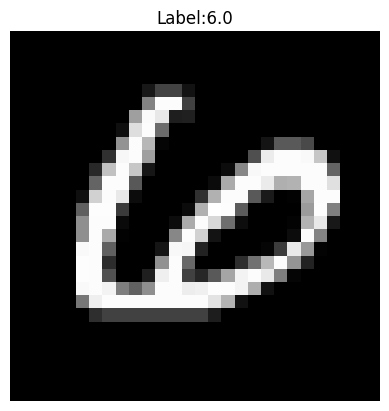

torch.Size([1, 14, 14])

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels = 1,out_channels = 1,kernel_size=3,stride=1,padding = 1),
    nn.MaxPool2d(2)
)

display_image(dataTensor[0],labelsTensor[0])

output = model(dataTensor[0])
output.shape


In [ ]:
# We could either use sequential or Classes. It is better to use classes because it gives more flexibility

class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1,padding=1) # 6,28,28
    self.pool1 = nn.MaxPool2d(2)                                                          # 6,14,14
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=3,kernel_size=3,stride=1,padding=1) # 3,14,14
    self.pool2 = nn.MaxPool2d(2)                                                          #3,7,7
    #self.conv3 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1) # 3,7,7
    #self.pool3 = nn.MaxPool2d(2)
                                                                                          #3,3,3
    self.ffn = nn.Linear(3*7*7,32)
    self.output = nn.Linear(32,10)

    self.dropout = nn.Dropout(.25)
    self.bn1 = nn.BatchNorm1d(32)

  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(self.pool1(x))

    x = self.conv2(x)
    x = F.relu(self.pool2(x))

    #x = F.relu(self.pool3(self.conv3(x)))

    x = torch.flatten(x,1)
    x = F.relu(self.bn1(self.ffn((x))))
    x = self.dropout(x)
    out = self.output(x)

    return out


In [ ]:
# We could either use sequential or Classes. It is better to use classes because it gives more flexibility

class CNN_act(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1,padding=1) # 6,28,28
    self.pool1 = nn.MaxPool2d(2)                                                          # 6,14,14
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=3,kernel_size=3,stride=1,padding=1) # 3,14,14
    self.pool2 = nn.MaxPool2d(2)                                                          #3,7,7
    self.conv3 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1) # 3,7,7
    self.pool3 = nn.MaxPool2d(2)
                                                                                          #3,3,3
    self.ffn = nn.Linear(3*3*3,32)
    self.output = nn.Linear(32,10)

    self.dropout = nn.Dropout(.25)
    self.bn1 = nn.BatchNorm1d(32)

  def forward(self,x,return_acts = False):
    conv_act1 = self.conv1(x)
    x = F.relu(self.pool1(conv_act1))

    conv_act2 = self.conv2(x)
    x = F.relu(self.pool2(conv_act2))

    conv_act3 = self.conv3(x)
    x = F.relu(self.pool3(conv_act3))

    x = torch.flatten(x,1)
    x = F.relu(self.bn1(self.ffn((x))))
    x = self.dropout(x)
    out = self.output(x)

    if(return_acts):
      return out,conv_act1,conv_act2,conv_act3
    else:
      return out


# Traning the model

The core loop of training an ML model remains the same

1. Get data,labels from your data loader
2. Get predictions from your model
3. Compute the loss
4. Log you results -> loss/accuracy
5. Backpropagation




In [ ]:
def plot_training_curves(train_loss, train_acc, test_loss, test_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12,5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label=f'Train Loss: {train_loss[-1]:.3f}')
    plt.plot(epochs, test_loss, 'r', label=f'Val Loss: {test_loss[-1]:.3f}')
    plt.title(f'Loss over Epochs ')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label=f'Train Accuracy: {train_acc[-1]:.3f}')
    plt.plot(epochs, test_acc, 'r', label=f'Val Accuracy: {test_acc[-1]:.3f}')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
#Train Normal Model
from tqdm import tqdm
epochs = 100
net = CNN()
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=.001)

train_loss = []
train_acc = []

test_loss = []
test_acc = []

for epoch in tqdm(range(epochs)):
  net.train()
  batch_loss = []
  batch_acc = []
  for x,y in trainLoader:

    preds= net(x)
    y = y.long()
    loss = lossfunc(preds,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    matches = 100*torch.mean((torch.argmax(preds,axis = 1) == y).float())
    batch_acc.append(matches)
    batch_loss.append(loss.item())
  train_loss.append(np.mean(batch_loss))
  train_acc.append(np.mean(batch_acc))

  # Evaluate the Model
  net.eval()


  with torch.no_grad():
    for x_test,y_test in valLoader:
      test_pred = net(x_test)
      y_test = y_test.long()
      test_l = lossfunc(test_pred,y_test)
      test_loss.append(test_l.item())

      matches = 100*torch.mean((torch.argmax(test_pred,axis = 1) == y_test).float())
      test_acc.append(matches)




100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


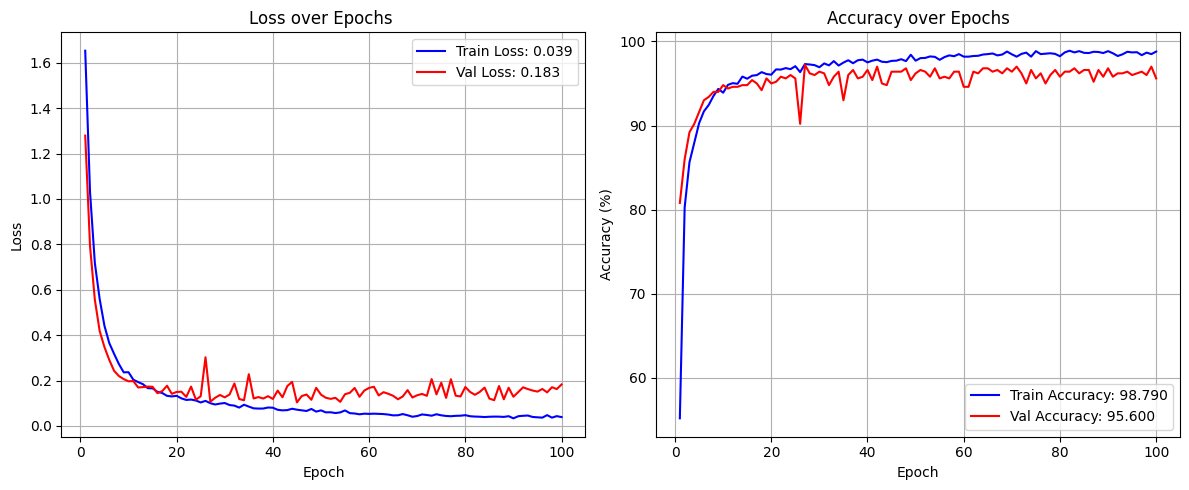

In [ ]:
plot_training_curves(train_loss,train_acc,test_loss,test_acc)

In [ ]:
#Train the model that returns the activation maps
#Train Normal Model
from tqdm import tqdm
epochs = 100
net_act = CNN_act()
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_act.parameters(),lr=.001)

train_loss = []
train_acc = []

test_loss = []
test_acc = []

for epoch in tqdm(range(epochs)):
  net_act.train()
  batch_loss = []
  batch_acc = []
  for x,y in trainLoader:

    preds= net_act(x)
    y = y.long()
    loss = lossfunc(preds,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    matches = 100*torch.mean((torch.argmax(preds,axis = 1) == y).float())
    batch_acc.append(matches)
    batch_loss.append(loss.item())
  train_loss.append(np.mean(batch_loss))
  train_acc.append(np.mean(batch_acc))

  # Evaluate the Model
  net.eval()


  with torch.no_grad():
    for x_test,y_test in valLoader:
      test_pred = net_act(x_test)
      y_test = y_test.long()
      test_l = lossfunc(test_pred,y_test)
      test_loss.append(test_l.item())

      matches = 100*torch.mean((torch.argmax(test_pred,axis = 1) == y_test).float())
      test_acc.append(matches)





100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


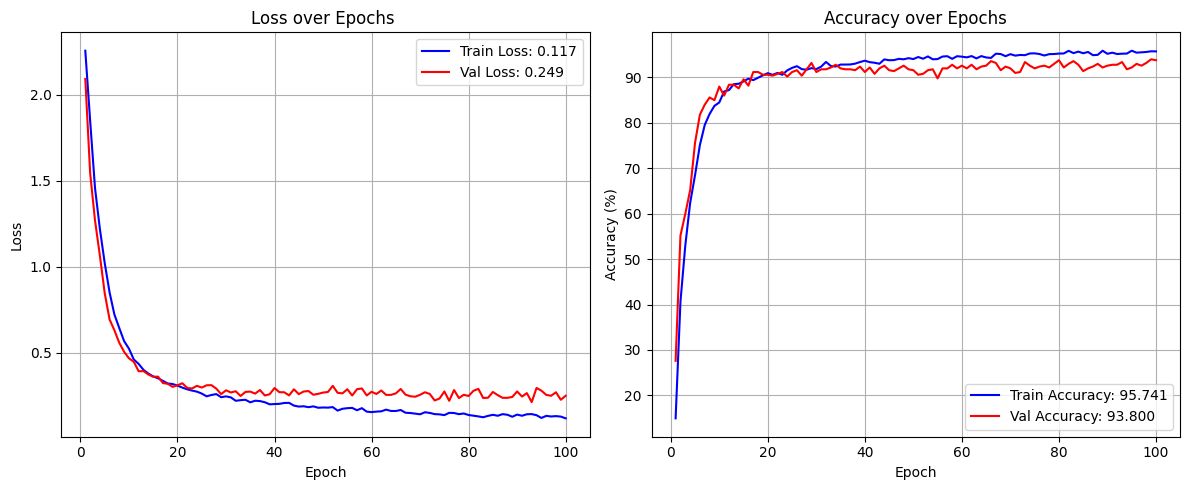

In [ ]:
plot_training_curves(train_loss,train_acc,test_loss,test_acc)

# Lets Run some tests





Here we are returning the activation maps(Output of the conv layer) and displaying for 5 images

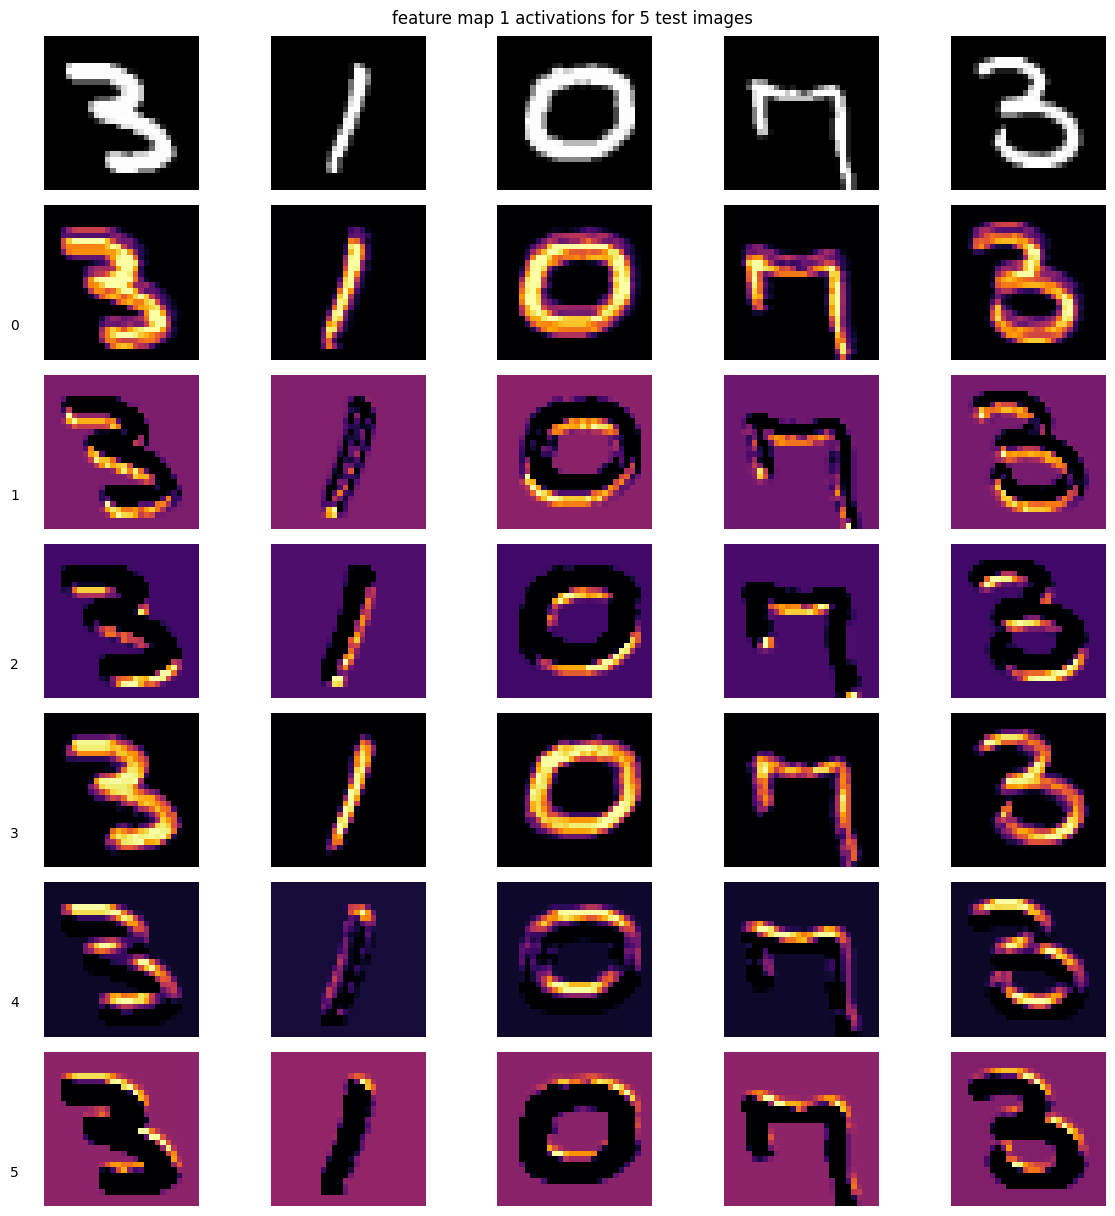

In [ ]:
X,y = next(iter(testLoader)) # extract X,y from test dataloader
yHat,featmap1,featmap2,featmap3 = net_act(X,True)



fig,axs = plt.subplots(1+featmap1.shape[1],5,figsize=(12,12))

for pici in range(5):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='gray',vmin=0,vmax=1)
  axs[0,pici].axis('off')

  for feati in range(6):
    # extract the feature map from this image
    img = featmap1[pici,feati,:,:].detach()
    vmax = torch.max(img).item()
    if vmax < 1e-5:
        vmax = 1e-5
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,22,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('feature map 1 activations for 5 test images',x=.5,y=1.01)
plt.show()




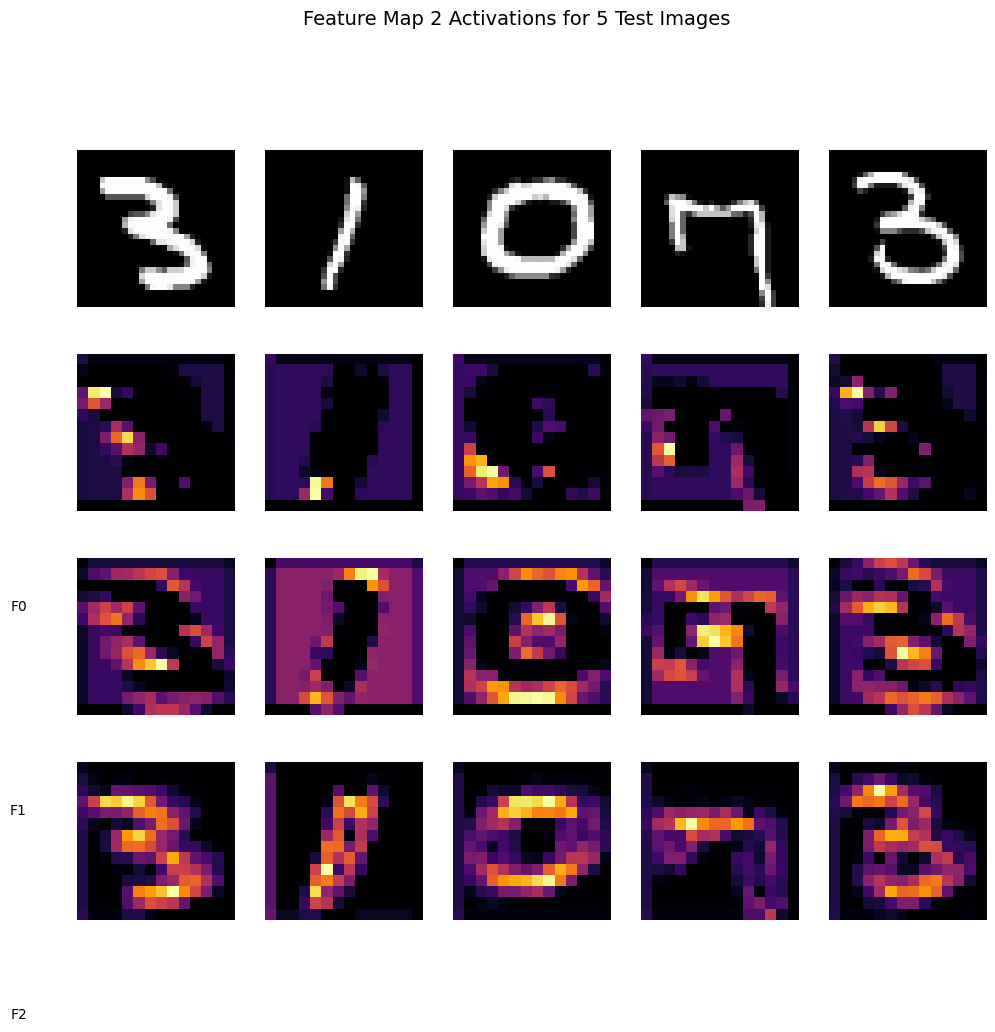

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(12, 10))

for pici in range(5):
    img = X[pici, 0, :, :].detach()
    axs[0, pici].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[0, pici].axis('off')

    for feati in range(3):
        fmap = featmap2[pici, feati, :, :].detach()
        vmax = torch.max(fmap).item()
        if vmax < 1e-5:
            vmax = 1e-5
        axs[feati+1, pici].imshow(fmap, cmap='inferno', vmin=0, vmax=vmax)
        axs[feati+1, pici].axis('off')
        if pici == 0:
            axs[feati+1, pici].text(-5, 22, f'F{feati}', ha='right', va='center', fontsize=10)

plt.subplots_adjust(hspace=0.3, wspace=0.05)
plt.suptitle('Feature Map 2 Activations for 5 Test Images', x=0.5, y=1.02, fontsize=14)
plt.show()


/tmp/ipython-input-1902510627.py:20: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


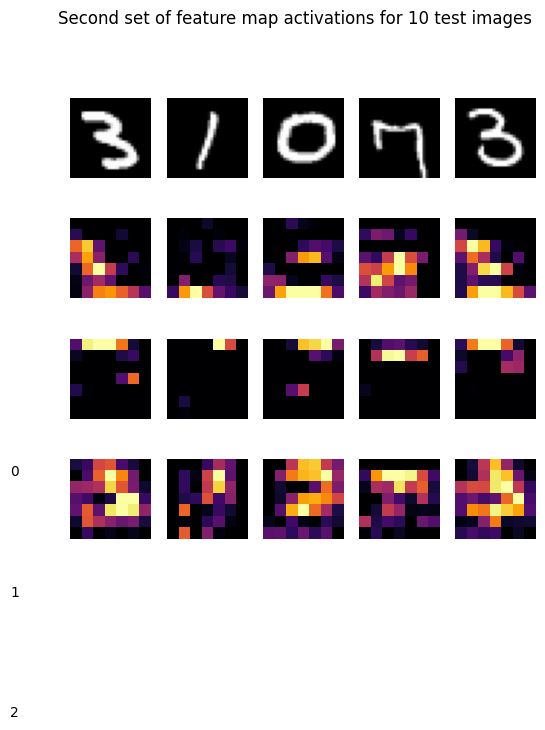

In [ ]:
fig,axs = plt.subplots(4,5,figsize=(6,6))

for pici in range(5):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='gray',vmin=0,vmax=1)
  axs[0,pici].axis('off')

  for feati in range(3):
    # extract the feature map from this image
    img = featmap3[pici,feati,:,:].detach()
    vmax = torch.max(img).item()
    if vmax < 1e-5:
        vmax = 1e-5
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,22,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

In [ ]:
def show_predictions(x,y,net,num_images = 16):
  x = x.to("cpu")
  y = y.to("cpu")
  net = net.to("cpu")
  net.eval()
  with torch.no_grad():
    x_disp = x[:num_images,:,:,:]
    y_disp = y[:num_images]

    preds = net(x_disp)
    predicted_labels = torch.argmax(preds,dim=1)
  images = x_disp.numpy()
  true_labels = y_disp.numpy()
  pred_labels = predicted_labels.numpy()
  plt.figure(figsize = (12,12))
  for i in range(len(x_disp)):
    plt.subplot(int(num_images**.5),int(num_images**.5),i+1)
    plt.imshow(images[i][0],cmap='grey')
    color = 'green' if pred_labels[i] == true_labels[i] else 'red'
    plt.text(0.5, -0.1, f"P:{pred_labels[i]} | T:{true_labels[i]}",
              color='white', fontsize=12,
              ha='center', transform=plt.gca().transAxes,
              bbox=dict(facecolor=color, alpha=0.8, boxstyle='round,pad=0.2'))

    plt.axis('off')
  plt.tight_layout()
  plt.show()


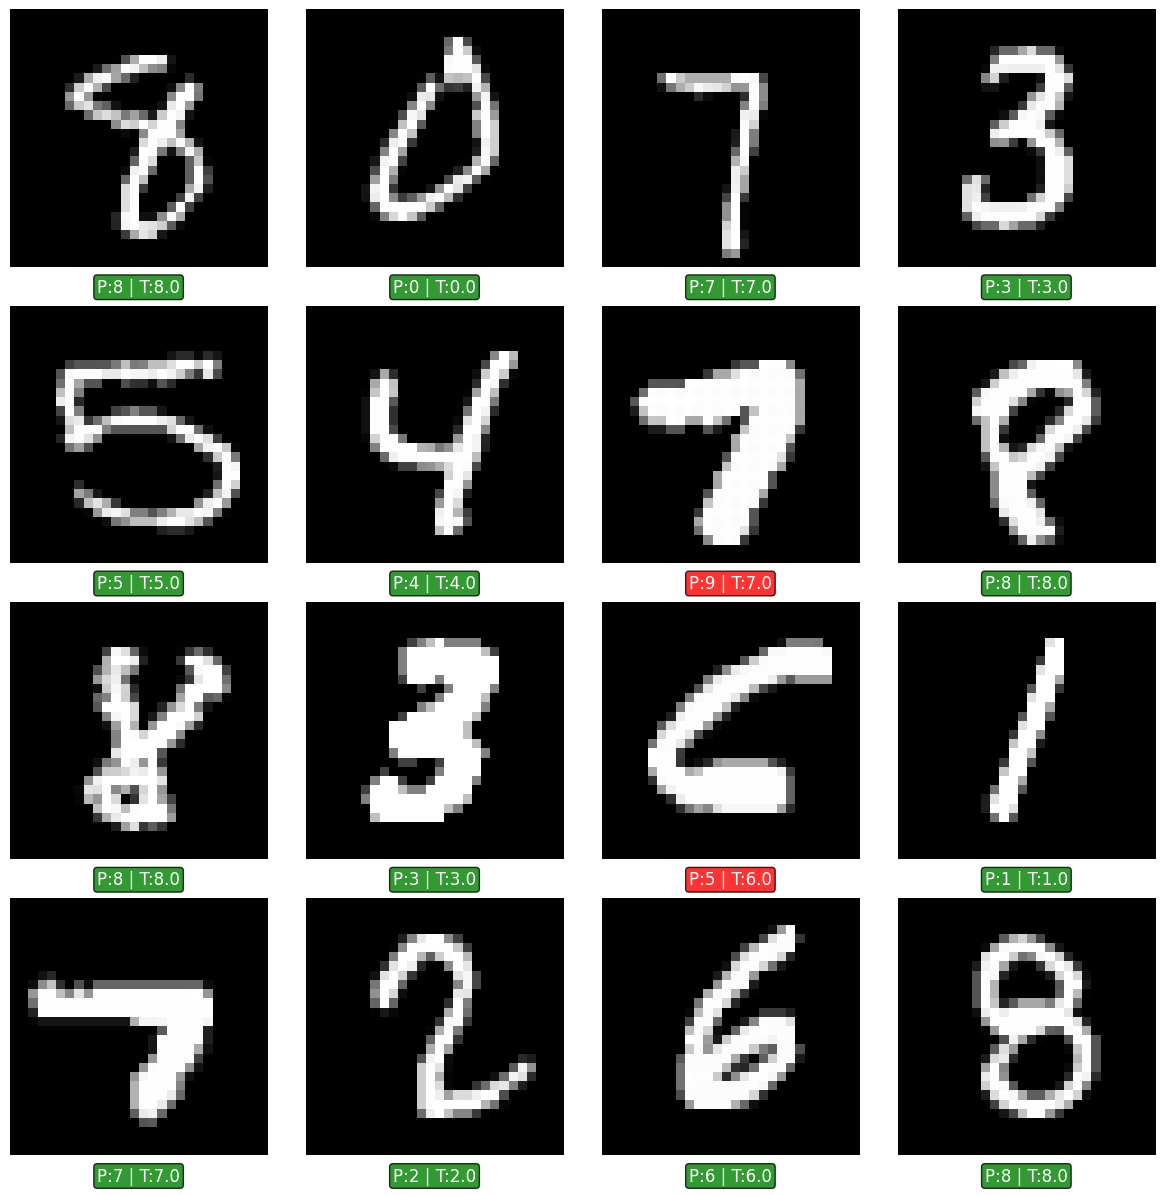

In [ ]:
x,y = next(iter(testLoader))

show_predictions(x,y,net)

Lets shift the image and then check if the model still performs


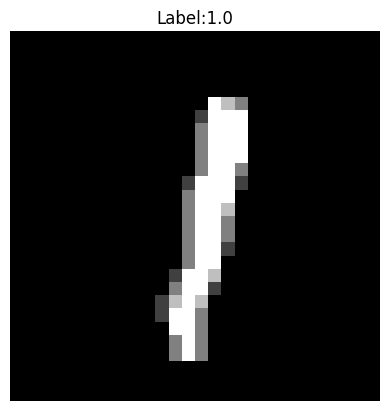

In [ ]:
X,y = next(iter(testLoader))
img = X[0].cpu()
label = y[0].cpu()
display_image(img,label)



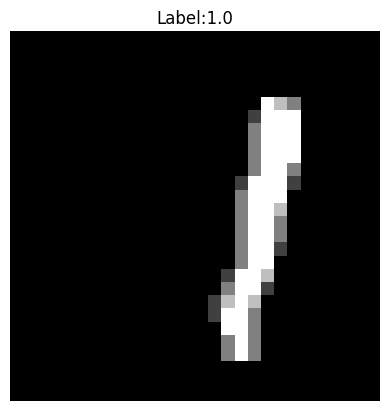

In [ ]:
roll = torch.roll(img,4,2)
display_image(roll,label)

In [ ]:
net_act.eval()
p = net_act(roll.unsqueeze(0))
print(torch.argmax(p,dim=1))

tensor([1])


In [ ]:
test_data_copy = test_data.clone().cpu()
test_labels_copy = test_labels.clone().cpu()

duplicate_dataset = TensorDataset(test_data_copy, test_labels_copy)

test_shifted = testLoader = DataLoader(duplicate_dataset,batch_size=duplicate_dataset.tensors[0].shape[0],shuffle=True,drop_last=True)

In [ ]:

for i in range(test_shifted.dataset.tensors[0].shape[0]):

  # get the image
  img = test_shifted.dataset.tensors[0][i,:,:]

  # reshape and roll by 10 pixels
  #randroll = np.random.randint(-10,11)
  img = torch.roll( img ,4,dims=2 )

  # re-vectorize and put back into the matrix
  test_shifted.dataset.tensors[0][i,:,:] = img

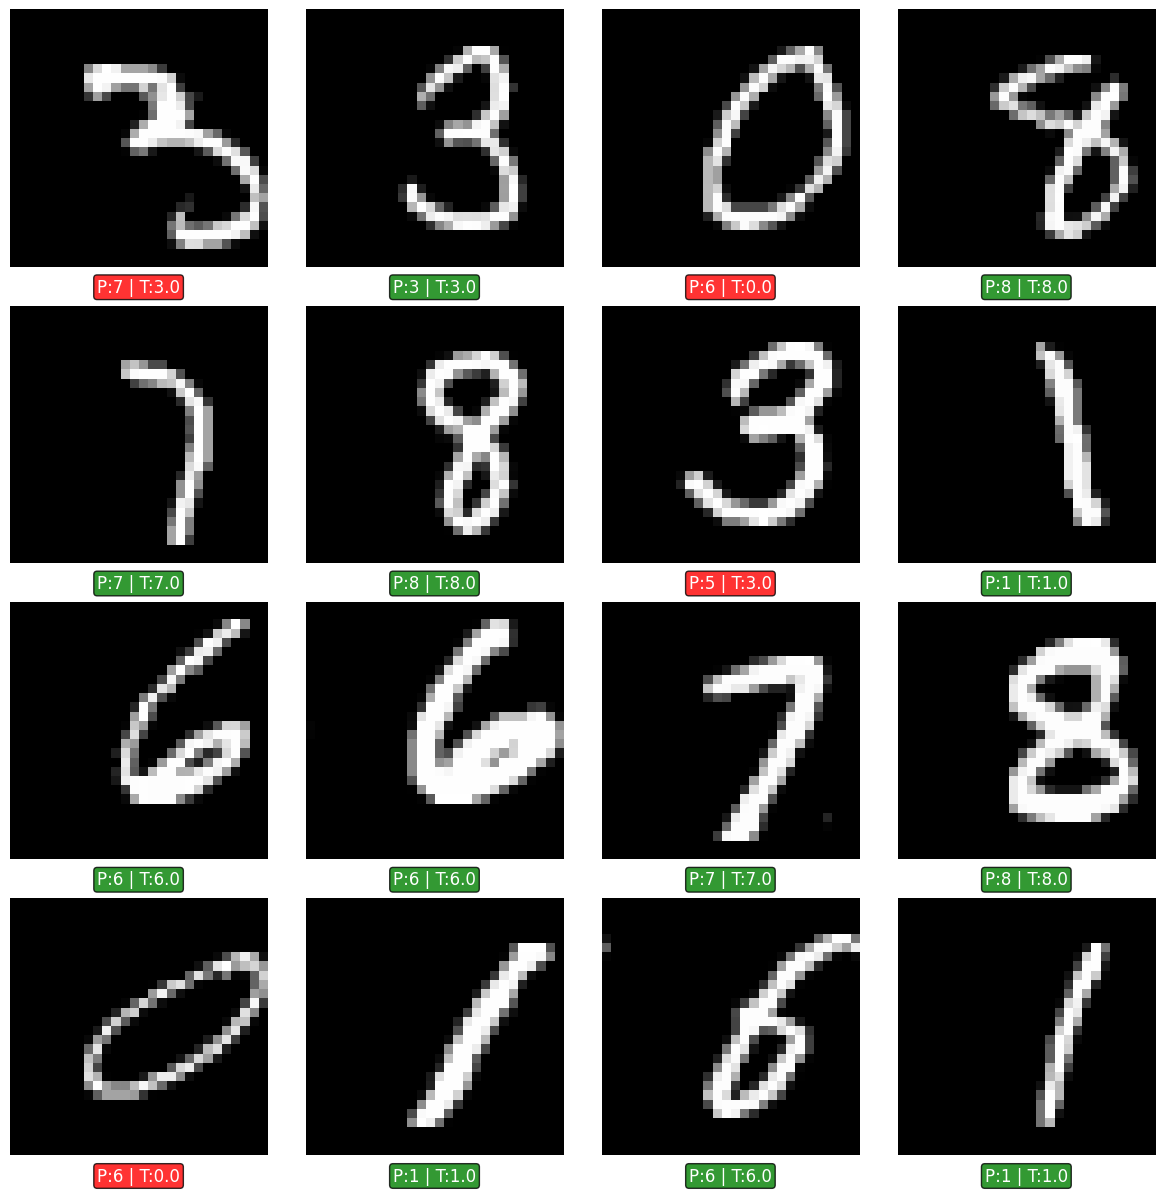

In [ ]:
x,y = next(iter(test_shifted))

show_predictions(x,y,net_act)

In [ ]:
net.eval()

shifted_acc = []
shifted_loss = []
with torch.no_grad():
  for x_test,y_test in test_shifted:
    test_pred = net(x_test)
    y_test = y_test.long()
    test_l = lossfunc(test_pred,y_test)
    shifted_loss.append(test_l.item())

    matches = 100*torch.mean((torch.argmax(test_pred,axis = 1) == y_test).float())
    shifted_acc.append(matches)




In [ ]:
print(shifted_acc)

[tensor(64.4000)]


#Why can we not get back into the 90s

1. MNIST is only 28x28
2. Shifting images by even small thresholds will move the important stuff outside the receptive region of the feature maps
3. Adding complexity to the model is not a great idea because it can lead to overfitting
4. However CNNs will generalize well for larger and more complex images

